In [2]:
import sys
import os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(os.path.join(project_root, 'src'))
from predictive_analysis.data_prediction_frost import main as frost_main
from predictive_analysis.data_prediction_nilu import main_nilu_prediction
frost_db_path = os.path.join(project_root, 'data', 'clean', 'frost.db')
nilu_file_path = os.path.join(project_root, 'data', 'clean', 'cleaned_data_nilu.json')

# 🔮 Prediktiv analyse av været og luftkvalitet i Trondheim

Tidligere i prosjektet har vi analysert hvordan både været og luftkvaliteten i Trondheim har utviklet seg de siste årene (se Notebook 02). I denne notebooken tar vi analysen et steg videre og forsøker å predikere hvordan temperatur og luftkvalitet kan utvikle seg i fremtiden, gitt at dagens trender fortsetter.

Prediktive modeller er nyttige fordi de hjelper oss å forstå mulige utviklingstrekk, og gir et grunnlag for langsiktig planlegging og tiltak. Selv om modellene vi har brukt er relativt enkle, kan de likevel gi verdifull innsikt – spesielt når fokuset ligger på overordnede mønstre fremfor presise daglige svingninger.

Vi har brukt **lineær regresjon** i begge analysene, implementert med [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fra `scikit-learn`. Modellene er bygget opp på ulike måter for å reflektere forskjeller i datastruktur og formål:

- **Temperaturmodellen (Frost-data):** Her har vi utvidet regresjonen med sesongbaserte funksjoner av tid, som `sin` og `cos` av dag i året, samt `Month` og `DayOfYear`. Dette gjør at modellen kan fange opp naturlige årstidsvariasjoner i temperaturene, noe som gir et mer realistisk bilde av utviklingen enn en enkel lineær trend. Uten slike sykliske komponenter ville modellen bare gi en rett linje, og ikke de årlige variasjonene vi vet finnes i et nordisk klima.
  
- **Luftkvalitetsmodellen (NILU-data):** Her har vi valgt en enklere tilnærming der vi modellerer den lineære utviklingen for hver enkelt komponent (NO₂, PM10, PM2.5) over tid. Hvert datapunkt representeres som et tallrekkeforløp, og regresjonen tegner en trendlinje og projiserer fremtidige verdier basert på denne.

Begge modellene har sine begrensninger: De tar ikke hensyn til eksterne faktorer som værhendelser, politikk eller utslippskilder, og de antar at tidligere trender fortsetter uforandret. Likevel gir analysene et godt utgangspunkt for å forstå utviklingen og støtte videre beslutninger og analyser.

---

### 🌡️ Temperaturer

Vi starter med å se på utviklingen av temperaturer i Trondheim. Under vises en graf som kombinerer historiske data, regresjonsbasert trend og fremtidig prediksjon. Grafen er delt inn i tre tydelige komponenter:

- **Blå linje:** Treningsdata brukt til å trene modellen  
- **Grønn linje:** Valideringsdata som ikke ble brukt i treningen, men som brukes for å teste hvor godt modellen treffer  
- **Gul stiplet linje:** Modellens prediksjon frem i tid (2020–2025)

Vi ser tydelige sesongvariasjoner med varme somre og kalde vintre, og dette mønsteret fanges godt opp av modellen takket være bruk av sykliske funksjoner. Modellen gir dermed en realistisk fremstilling av temperaturutviklingen, selv om den ikke fanger opp kortvarige svingninger eller ekstreme værhendelser. Den fungerer best som et verktøy for å vurdere **langsiktige og gjentakende trender** i klimaet.



Modellens ytelse::
Mean Squared Error: 14.93
R² Score: 0.72


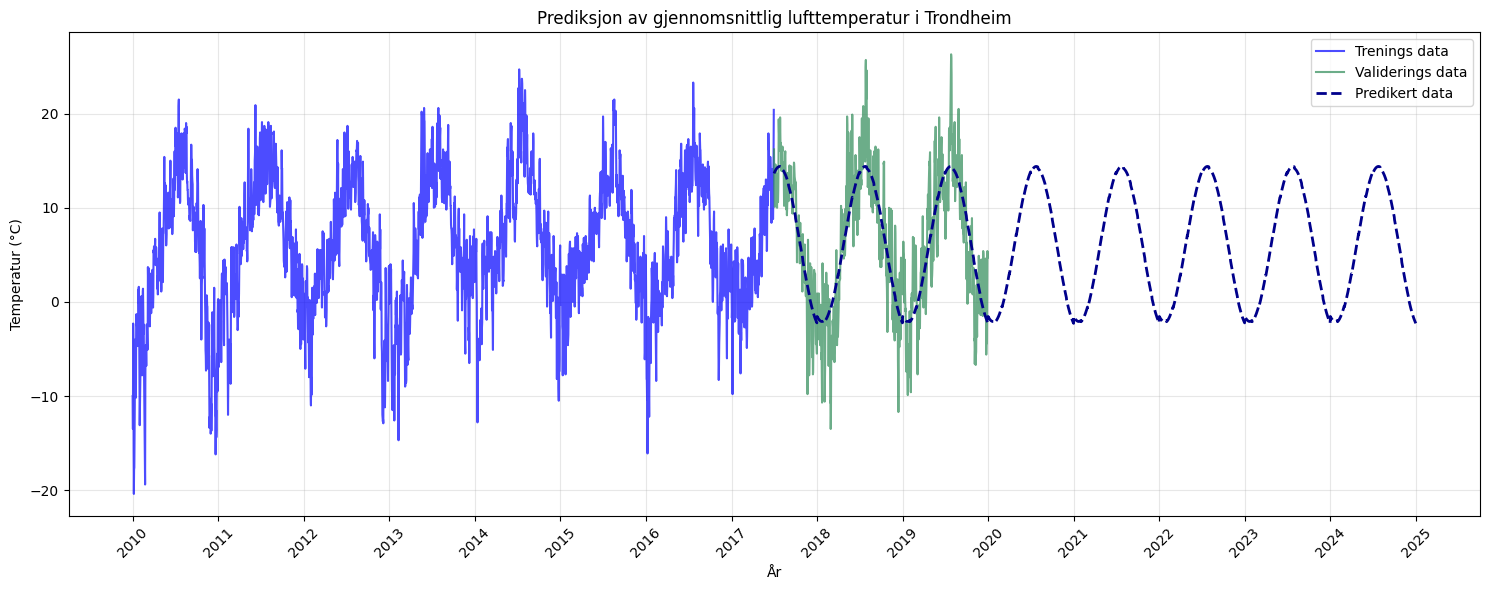

In [3]:
# Kjører Frost prediksjon
frost_main(frost_db_path, end_year=2024)

### 🌦️ Valg vi har gjort for modellen med Frost-data

For å predikere temperaturutviklingen i Trondheim har vi benyttet en utvidet form for **lineær regresjon**, implementert med [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fra `scikit-learn`. Valgene er gjort med utgangspunkt i analysen fra notebook 02, hvor vi så tydelige sesongvariasjoner og mønstre i temperaturdataene.

#### 📊 Dataforberedelse og rensing
- Vi har brukt et strukturert og renset datasett fra Frost API, hvor ekstreme verdier og feil er fjernet på forhånd.
- Kun daglige gjennomsnittstemperaturer (`mean_air_temperature`) er brukt som målvariabel.
- Datoene ble konvertert til `datetime`-format for å kunne behandles som tidsserier. For at modellen skal kunne fange opp de tydelige sesongmønstrene, beregnet vi sykliske funksjoner av datoen ved hjelp av `sin` og `cos`. Dette gjør at modellen kan gjenkjenne årlige variasjoner, som varme somre og kalde vintre, og gir en langt mer realistisk fremstilling enn en enkel lineær trend.

#### 🧠 Modellvalg og prediksjon
- I stedet for å bruke kun en lineær trend over tid, har vi utvidet modellen med **sykliske komponenter** (sinus og cosinus) for å fange opp de årlige svingningene.
- Modellen trenes på data frem til et gitt år (f.eks. 2018) og brukes deretter til å predikere utviklingen frem til 2024.
- Prediksjonen følger et realistisk bølgemønster, i motsetning til den rette linjen en enkel modell ville gitt.

#### 📈 Visualisering
- Resultatet vises i én samlet graf:
  - **Blå linje:** treningsdata
  - **Grønn linje:** valideringsdata (faktiske temperaturer etter treningsperioden)
  - **Gul stiplet linje:** modellens prediksjon fremover
- Vi bruker `matplotlib` med tilpasset datoformat på x-aksen for å gjøre det enkelt å følge temperaturutviklingen over år.

#### ⚠️ Begrensninger og ytelse
- Modellen fanger ikke opp ekstreme hendelser eller uvanlige temperaturforhold som skyldes spesifikke klimafenomener.
- Den bruker kun én målvariabel og er ikke koblet til eksterne faktorer som vind, nedbør eller CO₂-nivå.
- Modellen oppnår en R²-score på 0.72 og en MSE på 14.93, og forklarer dermed en stor andel av variasjonen i datasettet, men har begrenset presisjon for detaljerte værprognoser.
- Det er en relativt enkel modell, og den forutsetter at mønstre fra tidligere år vil fortsette i samme form.

#### 📍 Hvorfor dette likevel er nyttig
- Ved å kombinere lineær regresjon med sykliske funksjoner får vi en modell som balanserer enkelhet og realisme, og som gir en lettfattelig fremstilling av sesongvariasjoner.
- Modellen gir innsikt i mulig temperaturutvikling i Trondheim på lang sikt, og fungerer best som et verktøy for å forstå og reflektere over langsiktige og gjentakende trender – ikke for detaljerte korttidsprognoser.
- Dette kan brukes som et utgangspunkt for videre klimaanalyse og diskusjon.

---


## 🌫️ Luftkvalitet

Som vi så i den utforskende analysen (Notebook 02), har luftkvaliteten i Trondheim vist en gradvis forbedring det siste tiåret. Her forsøker vi å modellere denne utviklingen videre med prediktiv analyse.

Modellen er delt inn i tre separate grafer, én for hver komponent: NO₂, PM10 og PM2.5. Hver av dem viser utviklingen over tid, en trendlinje basert på lineær regresjon, og en fremskriving av hvordan nivåene kan utvikle seg de neste fem årene dersom dagens utvikling fortsetter.

- **Blå prikker:** Historiske daglige målinger  
- **Rød linje:** Trendlinje (lineær regresjon) trent på de historiske dataene  
- **Grønn stiplet linje:** Modellens prediksjon frem i tid

Vi ser at nivåene av alle tre komponentene viser en svak, men tydelig nedadgående trend over tid. Dette tyder på en forbedring i luftkvaliteten i Trondheim gjennom det siste tiåret. Prediksjonen fremover antyder at denne forbedringen kan fortsette – forutsatt at forholdene som påvirker luftkvaliteten forblir stabile.

Modellen fanger ikke opp sesongvariasjoner, policyendringer eller uvanlige utslipp, og bør derfor tolkes med forsiktighet. En enkel lineær modell kan dessuten gi urealistiske prediksjoner langt frem i tid, som negative utslippsverdier. Likevel gir modellen en nyttig fremstilling av den overordnede utviklingen og kan være et verdifullt verktøy for videre refleksjon og tiltak innen miljøforvaltning.

---

ValueError: Neither `start` nor `end` can be NaT

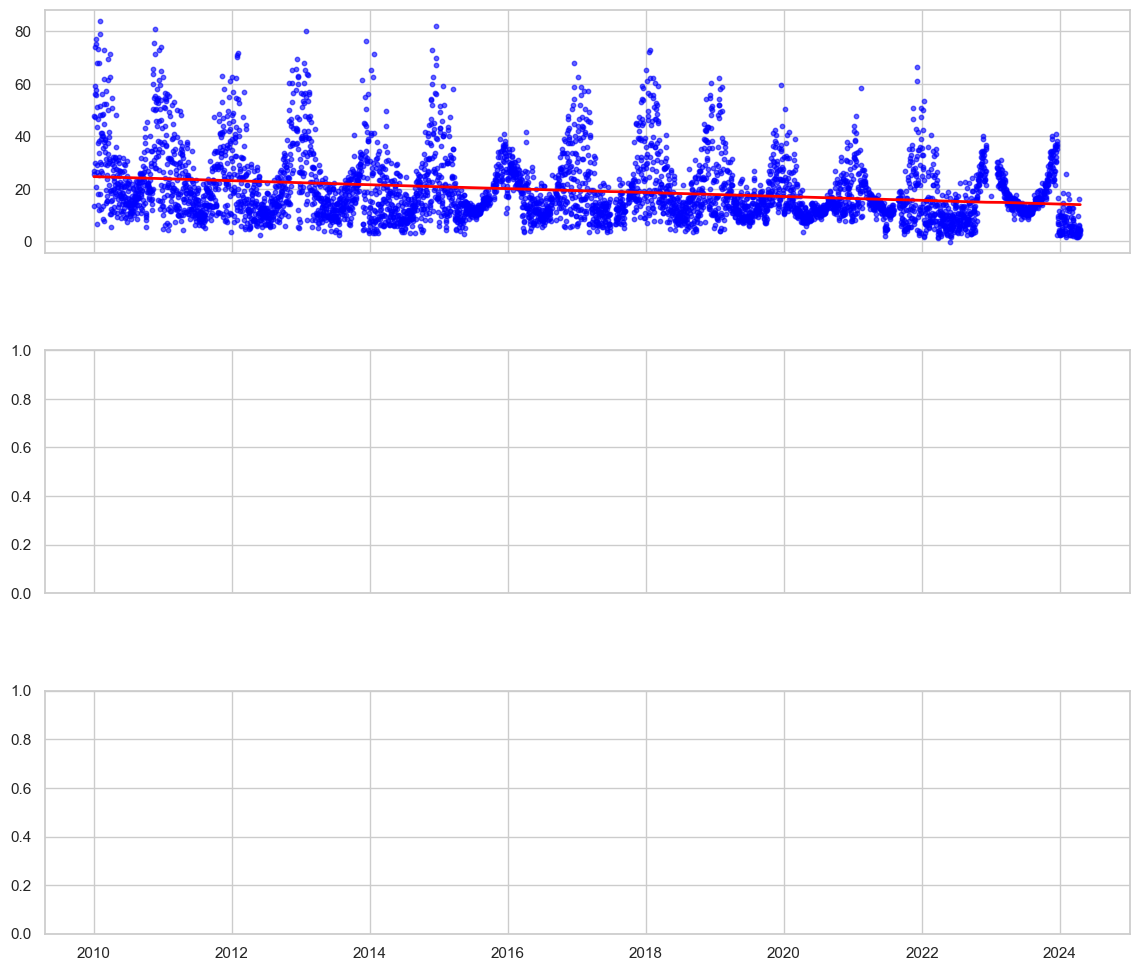

In [4]:
# Kjører NILU prediksjon
main_nilu_prediction(nilu_file_path)

### 🌫️ Valg vi har gjort for modellen med NILU-data

For å analysere og forutsi utviklingen i luftkvalitet har vi valgt å bruke en **enkel lineær regresjonsmodell** for hver enkelt luftkomponent (NO₂, PM10, PM2.5). Dette valget er basert på funnene fra notebook 02, der vi så at det ikke var tydelige sesongvariasjoner eller sterke sammenhenger mellom komponentene, men heller en svak, gradvis trend over tid.

Modellen er implementert med [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fra `scikit-learn`, og er brukt til å trekke en trendlinje gjennom de historiske målingene, samt å forutsi utviklingen 5 år frem i tid.

#### 📊 Dataforberedelse og rensing
- Vi har brukt et renset datasett som er lagret som JSON, der manglende verdier og ekstremverdier er behandlet på forhånd.
- Bare dager med komplette målinger for alle tre komponentene er brukt, for å sikre sammenlignbarhet.
- Datoene er konvertert til `datetime`-format og sortert, slik at utviklingen over tid kan modelleres korrekt.

#### 🧠 Modellvalg og prediksjon
- I motsetning til temperaturmodellen, som bruker flere tidsavhengige funksjoner (sin/cos), har vi valgt å bruke **en ren tidsbasert lineær regresjon** her. Dette er fordi luftkvalitet i Trondheim ikke viser like tydelige sesongvariasjoner.
- Hvert datapunkt tilordnes et stigende heltall (0, 1, 2, ...), som modellen bruker som uavhengig variabel for å lære trenden i komponentnivået over tid.
- Vi trener en individuell modell for hver komponent for å visualisere både:
  - En **regresjonslinje** som viser utviklingen i den historiske perioden.
  - En **fremtidig prediksjon**, som projiserer trenden 5 år framover basert på modellens forståelse.

#### 📈 Visualisering
- Vi har laget én graf per komponent, med tre klare visuelle elementer:
  - Blå prikker: historiske målinger
  - Rød linje: trendlinje (lineær regresjon)
  - Grønn stiplet linje: fremtidig prediksjon
- Grafene bruker `matplotlib` og `seaborn` for enkle og ryddige fremstillinger.
- Felles x-akse er formattert etter år, slik at det er lett å følge utviklingen over tid.

#### ⚠️ Begrensninger
- Modellen antar en **lineær utvikling** over tid, noe som ikke nødvendigvis stemmer med virkeligheten for luftkvalitet.
- Desto lengre man lar en slik modell generere, jo større er sjansen for å få feil verdier – for eksempel negative utslipp, som ikke er realistisk.
- Den fanger ikke opp sesongvariasjoner, policyendringer, trafikkregulering eller ekstreme hendelser.
- Vi modellerer **hver komponent separat**, og tar ikke hensyn til eventuelle sammenhenger mellom dem.

#### 📍 Hvorfor dette likevel er nyttig
- Selv om modellen er enkel, gir den en **intuitiv og lett forståelig fremstilling** av hvordan luftkvaliteten har utviklet seg – og hva som kan skje dersom utviklingen fortsetter som før.
- Dette kan brukes som et **utgangspunkt for videre analyser**, og gir visualiseringer som er nyttige for både beslutningstakere og publikum.

---

For mer informasjon om prosjektstrukturen, Git-bruken, refleksjonsnotatet og oversikt over de ulike delene, kan du besøke [**samlesiden**](../docs/samleside.md). Der finner du lenker videre til relevante notebooker og dokumentasjon.